## Imputing Missing Genres with NLP

I've come across comments on Reddit, Facebook, etc. from veteran Pitchfork readers that claim the site has diluted its indie focus with heavier promotion of pop and rap artists over the past decade. Has there been a shift in genre coverage? If so, has the shift affected Pitchfork's overall sentiment for any particular genres? 

Unfortunately, over 11% of reviews I scraped didn't contain a genre HTML tag; however, there are likely strong associations between certain words/phrases and their corresponding genres within the 89% of reviews without missing values. I've had success with classifying Rotten Tomatoes reviews as Rotten vs. Fresh using Naive Bayes, so I decided to tackle genre classification in a similar fashion.

### Step 1: Import necessary libraries for NLP, Naive Bayes, and data manipulation

In [1]:
#Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

#Import text processing libraries
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
import nltk
import contractions
#Run the next line to install nltk corpuses the first time.
#nltk.download()

#Import sklearn libraries for modeling
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#Import pyplot for visuals
import matplotlib.pyplot as plt

### Step 2: Visualize Review Counts by Genre

In [2]:
#Import Data
full_df = pd.read_pickle('p4k_clenased.pkl')

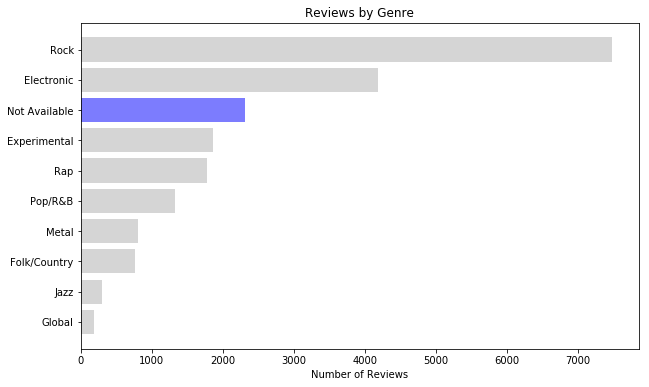

In [3]:
#Visualize Genre counts
counts_by_genre = full_df.groupby('Genre').size().reset_index(name='Counts')
counts_by_genre['Color'] = np.where(counts_by_genre['Genre']=='Not Available', '#7c7cfe', '#D5D5D5')
counts_by_genre.sort_values('Counts', inplace=True)

genres = counts_by_genre['Genre']
counts = counts_by_genre['Counts']
colors = counts_by_genre['Color']
y_pos = np.arange(len(genres))

#Create bar chart for genres
plt.figure(figsize=(10,6))
plt.barh(y_pos, counts, color=colors)
plt.yticks(y_pos, genres)
plt.xlabel('Number of Reviews')
plt.title('Reviews by Genre')
plt.show()

Rock and Electronic were the most common review genres, followed by reviews with no available genre HTML tag. Accurately imputing these missing values saves a sizeable chunk of data that I would otherwise discard.

### Step 3: Prepare model data

In order to assess model performance, I needed to split the data into three chunks: 1) A training set with availble genres; 2) A testing set with available genres to compare; 3) The genreless data to impute.

In [4]:
#Get reviews with known genre
has_genre_ind = full_df['Genre'] != 'Not Available'
no_genre_ind = full_df['Genre'] == 'Not Available'
has_genre_df = full_df[has_genre_ind]
genreless_df = full_df[no_genre_ind]

Next, I transformed all reviews into numeric format using a CountVectorizer with some custom tuning for punctuation and contractions. I also transformed genre into encoded numeric values allowed by the MultinomialNB function.

In [5]:
#Replace contractions in the reviews
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#Create vecotrized array for all reviews
customStopWords=set(stopwords.words('english')+list(punctuation))
vectorizer = CountVectorizer(min_df=1e-4, stop_words=customStopWords)
x_counts = vectorizer.fit_transform(full_df['Review'].apply(replace_contractions))

#Set as a dense array
x_counts_dense = x_counts.todense()

#Separate array by whether Genre is known or not
x_counts_not_missing_genre = x_counts_dense[has_genre_ind]
x_counts_missing_genre = x_counts_dense[no_genre_ind]

#Get numeric representation of Genre
labelencoder = LabelEncoder()
y_not_missing_genre = labelencoder.fit_transform(has_genre_df['Genre'])

After transforming the data, I randomly selected 66% of reviews with genres as my training set and optimized the Laplace smoothing parameter $\alpha$. I decided to use macro F1 scores to measure model performance given the multi-class nature of the target variable.

In [6]:
#Split data into training and test
X_train, X_val, Y_train, Y_val = train_test_split(x_counts_not_missing_genre, y_not_missing_genre, test_size=0.34, random_state=815)

#the grid of parameters to search over
alphas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
max_f1_cross = -np.inf

for alpha in alphas:     
    #Add alpha argument to clf
    clf = MultinomialNB(alpha = alpha)
    
    #Find current iteration's mean cross-validated f1_macro score
    f1_cross =  cross_val_score(clf, X_train, Y_train, scoring='f1_macro', cv=5).mean()
    
    #Determine if the new f1_cross is the best
    if f1_cross > max_f1_cross:
        #If we have the best, update the values of best_alpha, best_min_df, and max_f1_cross to current iteration
        best_alpha = alpha
        max_f1_cross = f1_cross
            
#After running the loop for each combination of given alphas and min_dfs, report the optimized results
print("Maximum f1_cross of %.4f achieved when alpha = %.2f" % (max_f1_cross,best_alpha))

Maximum f1_cross of 0.6757 achieved when alpha = 0.10


### Step 4: Run Multinomial Naive Bayes model with optimized parameters

In [7]:
#Use Multinomial classifier
clf = MultinomialNB(alpha = best_alpha)
#Fit the function to given training values of x and y
my_model = clf.fit(X_train, Y_train)

In [8]:
#Find accuracy for training and testing data using the fitted model
#Use scikit's score function (mean accuracy on given data/labels)
training_accuracy = my_model.score(X_train, Y_train)
testing_accuracy = my_model.score(X_val, Y_val)

print("Training set prediction accuracy: %.4f" % (training_accuracy))
print("Testing set prediction accuracy: %.4f" % (testing_accuracy))

Training set prediction accuracy: 0.9445
Testing set prediction accuracy: 0.7734


The testing set's dip in accuracy suggests an overfit model. However, music genres bleed into one another, so I considered 77% accuracy to be absolute lowest estimate of true genre accuracy. The confusion matrix below shows that most 'incorrect' decisions predicted Rock—perhaps the most broad among the nine genres Pitchfork defines.

In [9]:
#Get a list of the test set's predictions and actual values
test_predictions = list(labelencoder.inverse_transform(clf.predict(X_val)))
test_actuals = list(labelencoder.inverse_transform(Y_val))

#Show a table of the predicted and actual genres

### Step 5: Impute missing genres using an updated model with all available data

I felt satisfied with the test results, so I combined all the data with defined genres to update my model. Finally, I used this model to predict genres for the chunk of genreless data.

In [10]:
#Build one with train and validation combined and predict missing genres
my_combined_model = clf.fit(x_counts_not_missing_genre, y_not_missing_genre)
predicted_genre = my_combined_model.predict(x_counts_missing_genre)

#Get predictions as actual labels
decoded_predicted_genre = list(labelencoder.inverse_transform(predicted_genre))

#Reassign Genre
genreless_df['Genre'] = decoded_predicted_genre

#Create new dataframe with genre filled out for everyone
impute_genre_df = has_genre_df.append(genreless_df)

#Write dataset to pickle
impute_genre_df.to_pickle("p4k_cleansed_imputed_genre.pkl")